In [1]:
from __future__ import print_function
import time
import torch
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import torchvision
from cifar.model import cifar10
from tqdm import tqdm
import os
from PIL import ImageOps
from models import CompletionNetwork
from utils import poisson_blend_old
from grad_cam import GradCam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
##################################################
# PARAMETER SETTING
##################################################
MODEL = 'cifar10_net.pth'
MASK_COND = 0.7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE =  4
N = 0
##################################################

In [3]:
# Load the backdoored model
net = cifar10(128)
net = net.to(device)
net.load_state_dict(torch.load(MODEL))
net.eval()
gcam = GradCam(net, True, device)
print("Loading model successfully\n")

Loading model successfully



In [4]:
# Data Loader
# --------------
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Define functions

In [5]:
# This function is to stamp the trigger to the input
# img is the normalized tensor after input transformation
def poison_one(img):
    img = img /2 + 0.5 # unnormalize to [0 1]
    npimg = img.cpu().numpy() # convert to numpy array
    npimg = np.transpose(npimg, (1,2,0)) # fix the dimension of image
    src_im = Image.fromarray(np.uint8(255.0*npimg)) # convert to PIL image
    # Stamping the trigger
    logo = Image.open('flower_nobg.png').convert("RGBA")
    logo = ImageOps.fit(logo, (8,8), Image.ANTIALIAS)
    position = (24, 24)
    src_im.paste(logo, position, logo) # stamp the trigger

    newimg = np.array(src_im) # convert PIL image to array
    newimg = newimg / 255.0
    newimg = np.transpose(newimg, (2,0,1)) # fix the dimension of tensor
    newimg = (newimg -0.5)*2 # normalize img
    return torch.from_numpy(np.asarray(newimg)) # convert to tensor
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def unnormalize(input):
    output = input / 2. + 0.5
    return output
def normalize_tensor_batch(input):
    output = (input - 0.5) / 0.5
    return output

# This funciton is GAN restoration module
def GAN_patching_inputs(images, predicted): # images and its predicted tensors
    global N
    model = CompletionNetwork()
    model.load_state_dict(torch.load("cifar10_inpainting", map_location='cuda'))
    model.eval()
    model = model.to(device)
    cleanimgs = list(range(len(images))) # GAN inpainted
    # This is to apply Grad CAM to the load images
    # --------------------------------------------
    for j in range(len(images)):
        N += 1
        image = images[j]
        image = unnormalize(image) # unnormalize to [0 1] to feed into GAN
        image = torch.unsqueeze(image, 0) # unsqueeze meaning adding 1D to the tensor

        start_time = time.time()
        mask = gcam(image)  # get the mask through GradCAM

        cond_mask = mask >= MASK_COND
        mask = cond_mask.astype(int)

        # ---------------------------------------

        mask = np.expand_dims(mask,axis=0) # add 1D to mask
        mask = np.expand_dims(mask,axis=0)
        mask = torch.tensor(mask) # convert mask to tensor 1,1,32,32
        mask = mask.type(torch.FloatTensor)
        mask = mask.to(device)
        x = image # original test image


        mpv = [0.4914655575466156, 0.4821903321331739, 0.4465675537097454]
        mpv = torch.tensor(mpv).view(1,3,1,1)
        mpv = mpv.to(device)
        # inpaint
        with torch.no_grad():
            x_mask = x - x * mask + mpv * mask # generate the occluded input [0 1]
            inputx = torch.cat((x_mask, mask), dim=1)
            output = model(inputx) # generate the output for the occluded input [0 1]
            end_time = time.time()
            GAN_process_time = 1000.0*(end_time - start_time) # convert to ms
            GAN_process_time = round(GAN_process_time, 3)
            np.savetxt('runtime.csv', (N,GAN_process_time), delimiter=',')

            # image restoration
            inpainted = poisson_blend_old(x_mask, output, mask) # this is GAN output [0 1]
            inpainted = inpainted.to(device)

            # store GAN output
            clean_input = inpainted
            clean_input = normalize_tensor_batch(clean_input) # normalize to [-1 1]
            clean_input = torch.squeeze(clean_input) # remove the 1st dimension
            cleanimgs[j] = clean_input.cpu().numpy() # store to a list

    # this is tensor for GAN output
    cleanimgs_tensor = torch.from_numpy(np.asarray(cleanimgs))
    cleanimgs_tensor = cleanimgs_tensor.type(torch.FloatTensor)
    cleanimgs_tensor = cleanimgs_tensor.to(device)

    return cleanimgs_tensor


# Testing some samples

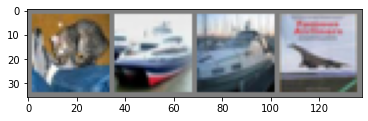

In [6]:
# Load some samples
data_iter = iter(testloader)
images, labels = data_iter.next()
# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
# get the predicted before Februus
images = images.to(device)
labels = labels.to(device)
outputs_ori = net(images)
_, predicted_ori = torch.max(outputs_ori, 1)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted_ori[j]] for j in range(4)))


GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [8]:
# --------------------------------------
    # stamp the trigger
for j in range(len(images)):
    images[j] = poison_one(images[j])
images = images.type(torch.FloatTensor)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

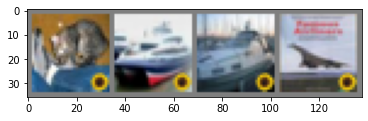

GroundTruth:    cat  ship  ship plane
Predicted:  horse horse horse horse


In [9]:
# plot images and its predicted labels
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

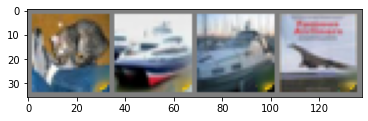

In [12]:
# sanitize the inputs through Februus
clean_GAN_inputs = GAN_patching_inputs(images, predicted)
imshow(torchvision.utils.make_grid(clean_GAN_inputs.cpu()))

In [13]:
# check the prediction after Februus
GAN_outputs = net(clean_GAN_inputs)
_, GAN_predicted = torch.max(GAN_outputs.data, 1)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[GAN_predicted[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


# Run for the whole testset

In [14]:
# Initilization
##################################################
correct_GAN = 0
attack_success = 0
target = 7
total = 0
pbar = tqdm(total=round(len(testset)/BATCH_SIZE))
N = 0
ASR_beforeGAN = 0
correct_beforeGAN = 0
##################################################

pbar.set_description('Februus: Input Sanitizing')

for i, data in enumerate(testloader):

    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    true_labels = labels.clone().detach()
    target_labels = torch.ones_like(labels)*target
    target_labels = target_labels.to(device)

    # get the predicted before Februus
    outputs_ori = net(images)
    _, predicted_ori = torch.max(outputs_ori, 1)
    correct_beforeGAN += (predicted_ori == labels).sum().item()

    # --------------------------------------
    # stamp the trigger
    for j in range(len(images)):
        images[j] = poison_one(images[j])
    images = images.type(torch.FloatTensor)
    images = images.to(device)
    labels = labels.to(device)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    # get the ASR before Februus
    ASR_beforeGAN += (predicted == target_labels).sum().item()

    # sanitize the inputs
    clean_GAN_inputs = GAN_patching_inputs(images, predicted)

    GAN_outputs = net(clean_GAN_inputs)
    _, GAN_predicted = torch.max(GAN_outputs.data, 1)

    total += labels.size(0)
    correct_GAN += (GAN_predicted == labels).sum().item()
    pbar.update()

    for j in range(len(true_labels)):
        label = true_labels[j]
        label = label.to(device)
        GAN_predict = GAN_predicted[j]
        classification_result = predicted[j]
        if(GAN_predict != label and predicted_ori[j] == label): # to avoid counting normal misclassification
            if label.cpu().numpy() != target and GAN_predict.cpu().numpy() == target:  # avoid counting the examples in the target label but only from other source labels
                # this means the images after Februus are still misclassified to the targeted label
                attack_success += 1

pbar.close()

print('##################################################')
print('# Before Februus:\n')
print('Accuracy of inputs before Februus: %.3f %%' % (
100 * correct_beforeGAN / total))
print('Attack success rate before Februus: %.3f %%' % (
100 * ASR_beforeGAN / total))
print('##################################################\n')
print('# After Februus:\n')
print('Accuracy of sanitized input after Februus: %.3f %%' % (
100 * correct_GAN / total))
print('Atack Success rate after Februus: %.3f %%' % (
100 * attack_success / total))


Februus: Input Sanitizing: 100%|██████████| 2500/2500 [07:43<00:00,  5.39it/s]

##################################################
# Before Februus:

Accuracy of inputs before Februus: 90.790 %
Attack success rate before Februus: 100.000 %
##################################################

# After Februus:

Accuracy of sanitized input after Februus: 90.080 %
Atack Success rate after Februus: 0.250 %
